# Fraud Detection Models

## Data Processing

In [1]:
# Append system path
import sys, os
sys.path.append(os.path.abspath('../modules'))

# Import pipeline modules
from raw_data_handler import Raw_Data_Handler
from dataset_design import Dataset_Designer
from feature_extractor import Feature_Extractor

# Create Class instances
data_handler = Raw_Data_Handler()
data_designer = Dataset_Designer()
feature_eng = Feature_Extractor()

In [2]:
# Define filepaths
customer_file = "../data_sources/customer_release.csv"
transactions_file = "../data_sources/transactions_release.parquet"
fraud_file = "../data_sources/fraud_release.json"

In [3]:
# Extract raw data from files 
customer_file, transactions_file, fraud_file = data_handler.extract(customer_file, transactions_file, fraud_file)
# Create cleaned raw data dataframe
raw_data = data_handler.transform(customer_file, transactions_file, fraud_file)

In [4]:
# Create train and test set
train_set, test_set = data_designer.sample(raw_data, test_size=0.2, random_state=42, stratify=True)

In [5]:
# Describe data
data_designer.describe()

{'version': '1.0',
 'storage': '',
 'description': {'training_set_size': 1186297,
  'test_set_size': 296575,
  'feature_count': 21,
  'training_class_distribution': {0.0: 0.9956191409065352,
   1.0: 0.00438085909346479},
  'test_class_distribution': {0.0: 0.9956199949422574,
   1.0: 0.004380005057742561}}}

In [6]:
# Apply feature engineering to train and test set
X_train, X_test, y_train, y_test, numeric_transformer, target_encoder = feature_eng.transform(train_set, test_set)

In [7]:
feature_eng.describe()

{'version': '1.0',
 'description': {'training_set_size': 1186297,
  'test_set_size': 296575,
  'feature_count': 11,
  'training_class_distribution': {0.0: 0.9956191409065352,
   1.0: 0.00438085909346479},
  'test_class_distribution': {0.0: 0.9956199949422574,
   1.0: 0.004380005057742561},
  'training_stats': {'amt': {'count': 1186297.0,
    'mean': 1.528841709140001e-17,
    'std': 1.0000004214798788,
    'min': -0.4321855564938597,
    '25%': -0.3781950933970811,
    '50%': -0.14312602240528596,
    '75%': 0.08245229197694734,
    'max': 181.51316097193893},
   'merch_lat': {'count': 1186297.0,
    'mean': 3.806657131741787e-15,
    'std': 1.0000004214798794,
    'min': -3.853186722187564,
    '25%': -0.7396794527180056,
    '50%': 0.16365405977123532,
    '75%': 0.6689349021939014,
    'max': 5.398447498961335},
   'merch_long': {'count': 1186297.0,
    'mean': 1.3468900795993352e-15,
    'std': 1.000000421479879,
    'min': -5.5035760524340125,
    '25%': -0.48956760033941277,
    

## Model Evaluation

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

def evaluate_model_with_custom_threshold(model, X_train, y_train, X_test, y_test, precision_min=0.3, recall_min=0.6):
    """
    Trains the provided model, finds the best threshold that maximizes F1-score with constraints on precision and recall,
    and evaluates the model using the custom threshold.
    
    Parameters:
    - model: The machine learning model to be trained and evaluated.
    - X_train: Training features.
    - y_train: Training labels.
    - X_test: Test features.
    - y_test: Test labels.
    - precision_min: Minimum required precision for valid thresholds.
    - recall_min: Minimum required recall for valid thresholds.
    
    Returns:
    - model: The trained model.
    - best_threshold: The best threshold that maximizes F1-score while satisfying the constraints.
    """
    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_test_prob = model.predict_proba(X_test)[:, 1]  # Probability for the positive class (class 1)

    # Calculate precision, recall, and thresholds
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_prob)

    # Calculate F1-scores for each threshold
    f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)

    # Apply precision and recall constraints
    valid_indices = np.where((precision_vals >= precision_min) & (recall_vals >= recall_min))[0]

    if valid_indices.size > 0:
        # Find the index of the maximum F1-score within the valid thresholds
        max_f1_index = valid_indices[np.argmax(f1_scores[valid_indices])]
        best_threshold = thresholds[max_f1_index]

        # Print the best threshold and corresponding metrics
        print(f"Best Threshold: {best_threshold:.2f}")
        print(f"F1-Score at Best Threshold: {f1_scores[max_f1_index] * 100:.2f}%")
        print(f"Precision at Best Threshold: {precision_vals[max_f1_index] * 100:.2f}%")
        print(f"Recall at Best Threshold: {recall_vals[max_f1_index] * 100:.2f}%")

        # Plot the Precision-Recall curve and mark the best threshold
        plt.figure(figsize=(8, 6))
        plt.plot(recall_vals, precision_vals, marker='.', label='Precision-Recall Curve')
        plt.scatter(recall_vals[max_f1_index], precision_vals[max_f1_index], marker='o', color='red', label='Best Threshold', s=100)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Return the trained model and best threshold
        return model, best_threshold
    else:
        print(f"No valid threshold found that satisfies precision >= {precision_min} and recall >= {recall_min}.")
        return model, None


### Define Models

In [17]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the models
random_forest = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    class_weight='balanced',  
    n_jobs=-1,
    random_state=42
)

bagging = BaggingClassifier(
    DecisionTreeClassifier(max_depth=10, random_state=42),  
    n_estimators=50,  
    max_features=1.0,  
    max_samples=0.8,   
    n_jobs=-1,       
    random_state=42
)

mlp = MLPClassifier(hidden_layer_sizes=(20, 30, 40),
                    activation='relu',
                    solver='adam',
                    learning_rate='constant',
                    tol=1e-5,
                    learning_rate_init=0.001,
                    early_stopping=True,
                    random_state=42, 
                    max_iter=500)

### Random Forest Model

Evaluating Random Forest Model:
Best Threshold: 0.23
F1-Score at Best Threshold: 74.43%
Precision at Best Threshold: 77.50%
Recall at Best Threshold: 71.59%


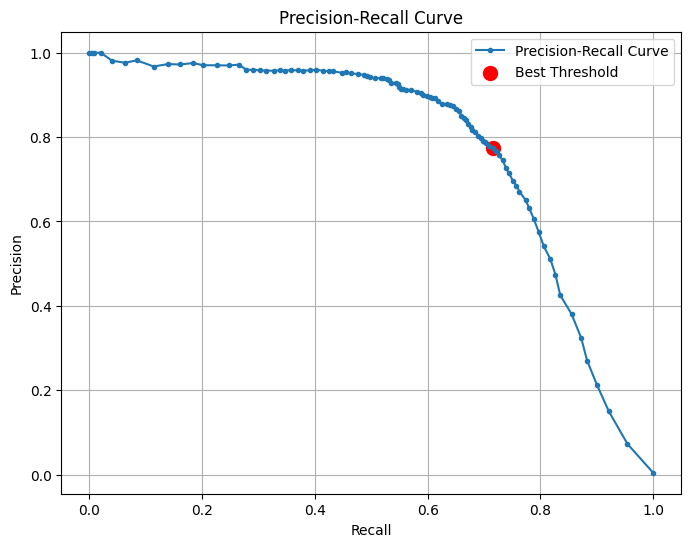

In [10]:
# Train and evaluate the Random Forest model
print("Evaluating Random Forest Model:")
trained_rf_model, best_rf_threshold = evaluate_model_with_custom_threshold(random_forest,
                                                                        X_train, y_train, X_test, y_test,
                                                                        precision_min=0.35, recall_min=0.7)

In [11]:
import joblib

# Create a dictionary to store both the model and the threshold
model_and_threshold = {
    'model': trained_rf_model,
    'threshold': best_rf_threshold,
    'numeric_transformer': numeric_transformer,
    'target_encoder': target_encoder
}

model_dir = '../storage/models/artifacts/random_forest_model_1'
os.makedirs(model_dir, exist_ok=True)

# Save the model and threshold together in a single file
filename = os.path.join(model_dir, 'model.pkl')
joblib.dump(model_and_threshold, filename)
print(f"Model and threshold saved to {filename}")

Model and threshold saved to ../storage/models/artifacts/random_forest_model_1/model.pkl


### Bagged Decision Tree Model


Evaluating Bagging Classifier Model:
Best Threshold: 0.41
F1-Score at Best Threshold: 75.06%
Precision at Best Threshold: 83.92%
Recall at Best Threshold: 67.90%


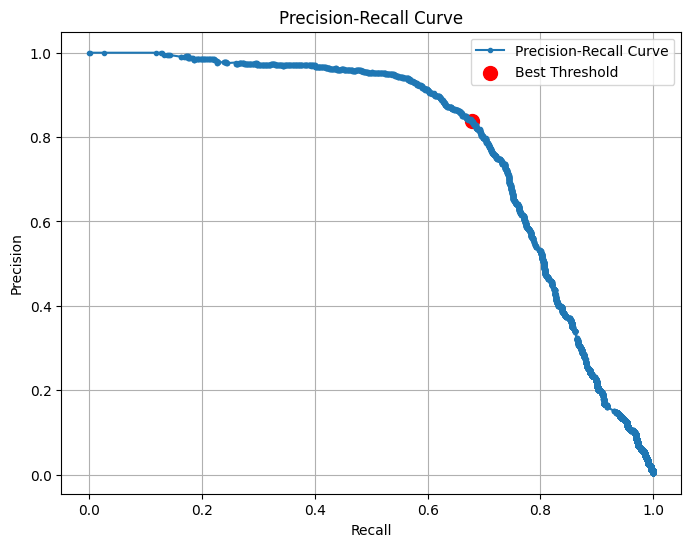

In [18]:
# Train and evaluate the Bagging Classifier model
print("\nEvaluating Bagging Classifier Model:")
trained_bagging_model, best_bagging_threshold = evaluate_model_with_custom_threshold(bagging,
                                                                                X_train, y_train, X_test, y_test,
                                                                                precision_min=0.35, recall_min=0.65)

In [19]:
# Create a dictionary to store both the model and the threshold
model_and_threshold = {
    'model': trained_bagging_model,
    'threshold': best_bagging_threshold,
    'numeric_transformer': numeric_transformer,
    'target_encoder': target_encoder
}


model_dir = '../storage/models/artifacts/bagging_model_1'
os.makedirs(model_dir, exist_ok=True)

# Save the model and threshold together in a single file
filename = os.path.join(model_dir, 'model.pkl')
joblib.dump(model_and_threshold, filename)
print(f"Model and threshold saved to {filename}")

Model and threshold saved to ../storage/models/artifacts/bagging_model_1/model.pkl


### Multilayer Perceptron Model


Evaluating MLP Classifier Model:
Best Threshold: 0.09
F1-Score at Best Threshold: 49.14%
Precision at Best Threshold: 39.49%
Recall at Best Threshold: 65.05%


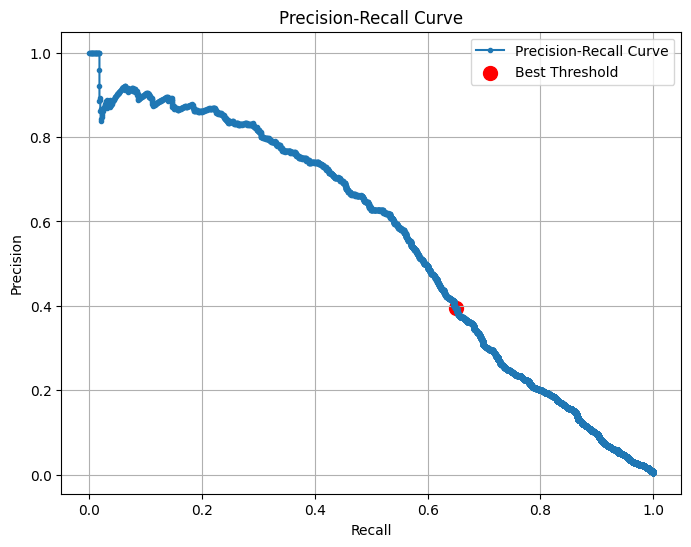

In [20]:
# Train and evaluate the MLP Classifier model
print("\nEvaluating MLP Classifier Model:")
trained_mlp_model, best_mlp_threshold = evaluate_model_with_custom_threshold(mlp,
                                                                        X_train, y_train, X_test, y_test,
                                                                        precision_min=0.35, recall_min=0.65)

In [21]:
# Create a dictionary to store both the model and the threshold
model_and_threshold = {
    'model': trained_mlp_model,
    'threshold': best_mlp_threshold,
    'numeric_transformer': numeric_transformer,
    'target_encoder': target_encoder
}

model_dir = '../storage/models/artifacts/mlp_model_1'
os.makedirs(model_dir, exist_ok=True)

# Save the model and threshold together in a single file
filename = os.path.join(model_dir, 'model.pkl')
joblib.dump(model_and_threshold, filename)
print(f"Model and threshold saved to {filename}")

Model and threshold saved to ../storage/models/artifacts/mlp_model_1/model.pkl
